In [28]:
# Step 1: Install the transformers library
!pip install transformers nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
# Step 2: Preprocess the data
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from pylab import plt, mpl

In [30]:
from google.colab import drive 
drive.mount('/content/drive')
df_temp_onestock_example=pd.read_csv('/content/drive/MyDrive/HKU/COMP7409 Machine learning in trading and finance/Project/AAPL.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
df_ori = df_temp_onestock_example
temp =df_ori[['Date','concatcontent']].drop_duplicates()
temp =df_ori
text = df_ori.groupby("Date")['concatcontent'].sum().to_frame("text").reset_index()
result = pd.merge(text,df_ori[['sscode','Date','adj_close_bef_tweet','adj_close_after_tweet','pct_ch_adj']].drop_duplicates(),on=['Date'],how='left')

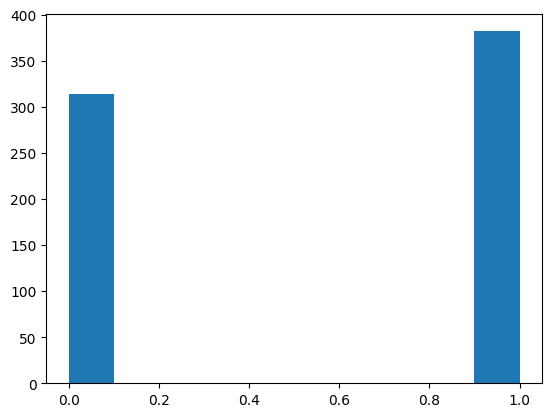

In [32]:
conditions = [
    (result['pct_ch_adj'] <= 0),
    (result['pct_ch_adj'] > 0)
    ]
values = [0, 1]
result['label'] = np.select(conditions, values)
plt.hist(result['label'])
df=result[['text','label']]

In [33]:
train_df, valid_test_df = train_test_split(df, test_size=0.4,random_state=42)
valid_df, test_df = train_test_split(valid_test_df, test_size=0.5,random_state=42)

In [45]:
train_df.to_csv('/content/drive/MyDrive/HKU/COMP7409 Machine learning in trading and finance/Project/train_df.csv', index=False)
valid_df.to_csv('/content/drive/MyDrive/HKU/COMP7409 Machine learning in trading and finance/Project/valid_df.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/HKU/COMP7409 Machine learning in trading and finance/Project/test_df.csv', index=False)

In [35]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [36]:
def encode_data(tokenizer, texts, labels, max_length):
    input_ids = []
    attention_masks = []

    for text in texts:
        token_data = tokenizer.encode_plus(
            text,
            max_length=max_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors="tf",
        )
        input_ids.append(token_data["input_ids"])
        attention_masks.append(token_data["attention_mask"])

    input_ids = tf.concat(input_ids, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)
    labels = tf.convert_to_tensor(labels)

    return input_ids, attention_masks, labels

max_length = 128
train_input_ids, train_attention_masks, train_labels = encode_data(tokenizer, train_df["text"].tolist(), train_df["label"].tolist(), max_length)
test_input_ids, test_attention_masks, test_labels = encode_data(tokenizer, test_df["text"].tolist(), test_df["label"].tolist(), max_length)
valid_input_ids, valid_attention_masks, valid_labels = encode_data(tokenizer, valid_df["text"].tolist(), valid_df["label"].tolist(), max_length)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [37]:
# Step 3: Apply data augmentation to the training data
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas

In [38]:
random.seed(0)
np.random.seed(0)

def augment_text(text, augmenters, num_augmented_texts_per_augmenter=1):
    augmented_texts = []

    for augmenter in augmenters:
        for _ in range(num_augmented_texts_per_augmenter):
            augmented_texts.append(augmenter.augment(text))

    return augmented_texts


# Initialize multiple augmenters
synonym_augmenter = naw.SynonymAug()
deletion_augmenter = naw.RandomWordAug(action="delete")
order_augmenter = naw.RandomWordAug(action="swap")

augmenters = [synonym_augmenter, deletion_augmenter, order_augmenter]

# Apply data augmentation to the training data
num_augmented_texts_per_augmenter = 1
augmented_texts = []
augmented_labels = []

for text, label in zip(train_df["text"], train_df["label"]):
    augmented = augment_text(text, augmenters, num_augmented_texts_per_augmenter)
    augmented_texts.extend(augmented)
    augmented_labels.extend([label] * len(augmented))

# Combine the original and augmented data
train_df_augmented = train_df.copy()
train_df_augmented = train_df_augmented.append(pd.DataFrame({"text": augmented_texts, "label": augmented_labels}), ignore_index=True)

# Tokenize and encode the augmented data
train_input_ids, train_attention_masks, train_labels = encode_data(tokenizer, train_df_augmented["text"].tolist(), train_df_augmented["label"].tolist(), max_length)

<ipython-input-38-bbabad2898e1>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df_augmented = train_df_augmented.append(pd.DataFrame({"text": augmented_texts, "label": augmented_labels}), ignore_index=True)


In [39]:
# Step 4: Build the custom model
from transformers import TFBertModel
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional, LSTM

In [40]:
bert_model = TFBertModel.from_pretrained("bert-base-uncased")
bert_model.trainable = False
# bert_model.trainable = True

input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
attention_masks = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="attention_masks")

input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
attention_masks = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="attention_masks")

bert_output = bert_model([input_ids, attention_masks])[0]
lstm_output = Bidirectional(LSTM(64, return_sequences=False))(bert_output)
dropout = Dropout(0.5)(lstm_output)
dense1 = Dense(64, activation="relu")(dropout)
dropout2 = Dropout(0.5)(dense1)
output = Dense(2, activation="softmax")(dropout2)

model = tf.keras.Model(inputs=[input_ids, attention_masks], outputs=output)

model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [41]:
# Step 5: Train and evaluate the model using the augmented data
batch_size = 32
num_epochs = 100
learning_rate = 5e-5
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(
    [train_input_ids, train_attention_masks],
    train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=([valid_input_ids, valid_attention_masks], valid_labels),
)

Epoch 1/100
53/53 [==============================] - 48s 411ms/step - loss: 0.7378 - accuracy: 0.5228 - val_loss: 0.7085 - val_accuracy: 0.4460
Epoch 2/100
53/53 [==============================] - 19s 369ms/step - loss: 0.7238 - accuracy: 0.4976 - val_loss: 0.7058 - val_accuracy: 0.4676
Epoch 3/100
53/53 [==============================] - 18s 335ms/step - loss: 0.7178 - accuracy: 0.4976 - val_loss: 0.7036 - val_accuracy: 0.5036
Epoch 4/100
53/53 [==============================] - 19s 359ms/step - loss: 0.7114 - accuracy: 0.5054 - val_loss: 0.7021 - val_accuracy: 0.5108
Epoch 5/100
53/53 [==============================] - 20s 374ms/step - loss: 0.7007 - accuracy: 0.5126 - val_loss: 0.7002 - val_accuracy: 0.4964
Epoch 6/100
53/53 [==============================] - 19s 354ms/step - loss: 0.6995 - accuracy: 0.5252 - val_loss: 0.7006 - val_accuracy: 0.5036
Epoch 7/100
53/53 [==============================] - 18s 344ms/step - loss: 0.7022 - accuracy: 0.5252 - val_loss: 0.6989 - val_accuracy:

In [42]:
model.save('/content/drive/MyDrive/HKU/COMP7409 Machine learning in trading and finance/Project/my_model.h5')

In [43]:
# Step 4: Evaluate the performance of the fine-tuned
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
predictions = model.predict([test_input_ids, test_attention_masks])
predicted_labels = predictions.argmax(axis=1)


# accuracy = np.sum(predicted_labels == test_labels.numpy()) / len(test_labels)
accuracy=accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels)
recall = recall_score(test_labels, predicted_labels)
f1 = f1_score(test_labels, predicted_labels)
print("Test Performance:")
print("accuracy:  {:.2f}%".format(accuracy * 100))
print("precision: {:.2f}%".format(precision * 100))
print("recall:    {:.2f}%".format(recall * 100))
print("F1 Score:  {:.2f}%".format(f1 * 100))

5/5 [==============================] - 5s 238ms/step
Test Performance:
accuracy:  58.57%
precision: 67.61%
recall:    57.83%
F1 Score:  62.34%


# Testing Area

In [ ]:
sent= 'how to train the model, lets look at how a trained model calculates its prediction.'
tokens=bert_tokenizer.tokenize(sent)
print(tokens)

['how', 'to', 'train', 'the', 'model', ',', 'lets', 'look', 'at', 'how', 'a', 'trained', 'model', 'calculate', '##s', 'its', 'prediction', '.']


In [ ]:
tokenized_sequence= bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =30,pad_to_max_length = True,return_attention_mask = True)
tokenized_sequence

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'input_ids': [101, 2129, 2000, 3345, 1996, 2944, 1010, 11082, 2298, 2012, 2129, 1037, 4738, 2944, 18422, 2015, 2049, 17547, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [ ]:
tokenized_sequence

{'input_ids': [101, 2129, 2000, 3345, 1996, 2944, 1010, 11082, 2298, 2012, 2129, 1037, 4738, 2944, 18422, 2015, 2049, 17547, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [ ]:
bert_tokenizer.decode(tokenized_sequence['input_ids'])

'[CLS] how to train the model, lets look at how a trained model calculates its prediction. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

(array([  0.,   0.,   0.,   0.,   0., 134.,   0.,   0.,   0.,   0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

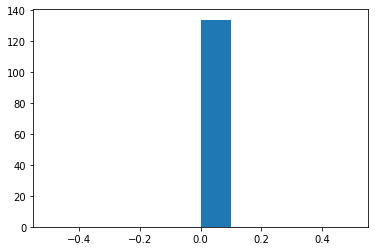

In [ ]:
d = {'Test':test_label,'Predict':pred_labels}
plt.hist(d["Predict"])

In [ ]:
prediction_check = pd.DataFrame(d)
prediction_check

,Test,Predict
0,0,0
1,1,0
2,-1,0
3,-1,0
4,0,0
...,...,...
129,-1,0
130,0,0
131,0,0
132,1,0


In [ ]:
prediction_check[prediction_check['Test']==prediction_check['Predict']]

,Test,Predict
0,0,0
4,0,0
7,0,0
10,0,0
11,0,0
...,...,...
124,0,0
125,0,0
126,0,0
130,0,0


In [ ]:
data['gt'] = data['label'].map({-1:-1,0:0,1:1})
sentences=data['text']
labels=data['gt']

<ipython-input-142-745bfd1513d1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['gt'] = data['label'].map({-1:-1,0:0,1:1})


In [ ]:
input_ids=[]
attention_masks=[]

for sent in sentences:
    bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length = 512,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

len(input_ids),len(attention_masks),len(labels)

(671, 671, 671)

In [ ]:
#first split 60% of training set
#half split remaining 40%, i.e. each validation & test set has 20%
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.4)
test_inp,val_inp,test_label,val_label,test_mask,val_mask=train_test_split(val_inp,val_label,val_mask,test_size=0.5)

print('Train inp shape {} Val input shape {} Test input shape {}\nTrain label shape {} Val label shape {} Test label shape {}\nTrain attention mask shape {} Val attention mask shape {} Test attention mask shape {}'.format(train_inp.shape,val_inp.shape,test_inp.shape,train_label.shape,val_label.shape,test_label.shape,train_mask.shape,val_mask.shape,test_mask.shape))


Train inp shape (402, 512) Val input shape (135, 512) Test input shape (134, 512)
Train label shape (402,) Val label shape (135,) Test label shape (134,)
Train attention mask shape (402, 512) Val attention mask shape (135, 512) Test attention mask shape (134, 512)


In [ ]:
#log_dir='tensorboard_data/tb_bert'
#model_save_path='./models/bert_model.h5'

#callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]



loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=num_classes)
#bert_model = TFDistilBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=num_classes)
bert_model.layers[0].trainable = False

bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])
print('\nBert Model',bert_model.summary())


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file tf_model.h5 from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tf_model.h5
All model checkpoint layers were used when 

Model: "tf_bert_for_sequence_classification_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_835 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 1,538
Non-trainable params: 109,482,240
_________________________________________________________________

Bert Model None


In [ ]:
history=bert_model.fit([train_inp,train_mask],train_label,batch_size=32,epochs=20,validation_data=([val_inp,val_mask],val_label))

Epoch 1/20
13/13 [==============================] - 46s 3s/step - loss: 0.6963 - accuracy: 0.5000 - val_loss: 0.6908 - val_accuracy: 0.5333
Epoch 2/20
13/13 [==============================] - 23s 2s/step - loss: 0.6923 - accuracy: 0.5149 - val_loss: 0.6925 - val_accuracy: 0.5111
Epoch 3/20
13/13 [==============================] - 28s 2s/step - loss: 0.6904 - accuracy: 0.5199 - val_loss: 0.6931 - val_accuracy: 0.4963
Epoch 4/20
13/13 [==============================] - 28s 2s/step - loss: 0.6874 - accuracy: 0.5423 - val_loss: 0.6945 - val_accuracy: 0.4815
Epoch 5/20
13/13 [==============================] - 28s 2s/step - loss: 0.6893 - accuracy: 0.5448 - val_loss: 0.6958 - val_accuracy: 0.4815
Epoch 6/20
13/13 [==============================] - 29s 2s/step - loss: 0.6897 - accuracy: 0.5224 - val_loss: 0.6954 - val_accuracy: 0.4815
Epoch 7/20
13/13 [==============================] - 29s 2s/step - loss: 0.6956 - accuracy: 0.5124 - val_loss: 0.6947 - val_accuracy: 0.4815
Epoch 8/20
13/13 [==

In [ ]:
preds = bert_model.predict([test_inp,test_mask],batch_size=32)
#pred_labels = preds.argmax(axis=1)
pred_labels = np.argmax(preds.logits, axis=1)
f1 = f1_score(test_label,pred_labels)
print('F1 score',f1)
print('Classification Report')
print(classification_report(test_label,pred_labels,target_names=['-1','0','1']))

5/5 [==============================] - 9s 1s/step
F1 score 0.07317073170731708
Classification Report


ValueError: ignored

In [ ]:
pred_drop_prob=[]
pred_rise_prob=[]
for i in predictions:
  pred_drop_prob.append(i[0])
  pred_rise_prob.append(i[1])

In [ ]:
predict_summary=pd.DataFrame()

predict_summary['pred_drop_prob']=pred_drop_prob
predict_summary['pred_rise_prob']=pred_rise_prob
predict_summary['pred_label']=predicted_labels
predict_summary['actual_label']=test_labels
predict_summary

,pred_drop_prob,pred_rise_prob,pred_label,actual_label
0,0.431607,0.568393,1,1
1,0.445715,0.554285,1,1
2,0.446205,0.553795,1,0
3,0.460062,0.539938,1,1
4,0.428890,0.571110,1,1
...,...,...,...,...
135,0.402612,0.597388,1,0
136,0.492554,0.507446,1,1
137,0.452368,0.547632,1,1
138,0.440579,0.559421,1,0


In [ ]:
predict_seg=predict_summary[predict_summary['pred_rise_prob']<0.5]
# predict_seg=predict_seg[predict_seg['pred_rise_prob']<0.52]
predict_seg[predict_seg['pred_label']==predict_seg['actual_label']].shape[0]/predict_seg.shape[0]

0.0

(array([ 2.,  0.,  1., 11., 16., 26., 31., 23., 24.,  6.]),
 array([0.46085289, 0.47450644, 0.48815995, 0.50181347, 0.51546705,
        0.52912056, 0.54277408, 0.5564276 , 0.57008111, 0.58373469,
        0.59738821]),
 <BarContainer object of 10 artists>)

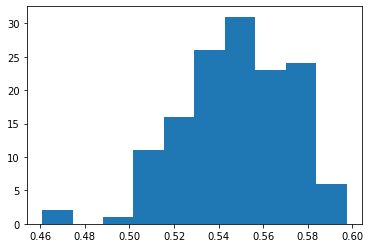

In [ ]:
plt.hist(pred_rise_prob)